In [1]:
import json
import textwrap
from typing import Any

import pandas as pd
from datasets import load_dataset
from langchain_core.utils.json import parse_json_markdown
from sklearn.metrics import ConfusionMatrixDisplay
from tabulate import tabulate

# Find missing mapping to id

In [2]:
ds = load_dataset("JuDDGES/pl-swiss-franc-loans", split="annotated").to_pandas()
ds.head()

,context,output
0,Sygn. akt XV C 1471/12\n\nWYROK\nW IMIENIU RZE...,"{""sprawa_frankowiczow"":""Nie"",""apelacja"":null,""..."
1,Sygn. akt V Ca 2924/12\n\nWYROK\nW IMIENIU RZE...,"{""sprawa_frankowiczow"":""Tak"",""apelacja"":""warsz..."
2,Sygn. akt I C 376/13\n\nWYROK\nW IMIENIU RZECZ...,"{""sprawa_frankowiczow"":""Tak"",""apelacja"":null,""..."
3,Sygn. akt I ACa 801/13\n\nWYROK\nW IMIENIU RZE...,"{""sprawa_frankowiczow"":""Tak"",""apelacja"":""Biały..."
4,Sygn. akt I ACa 812/13\n\nWYROK\nW IMIENIU RZE...,"{""sprawa_frankowiczow"":""Tak"",""apelacja"":""Gdańs..."


# Analyse results

In [3]:
DATASET = "pl_court_swiss_franc_loans"
LLM = "llama_3.1_8b_instruct"
PROMPT = "info_extraction_annotated_json"
SCHEMA = "swiss_franc_loans"
SEED = 7312

JUDGE_FILE = "llm_as_judge_gpt-4.1-mini-2025-04-14.json"
PRED_FILE = "predictions.json"

raw_dir = f"data/experiments/predict/raw_vllm/{DATASET}/annotated/{LLM}/{PROMPT}/{SCHEMA}/seed_{SEED}"
sft_dir = f"data/experiments/predict/fine_tuned_vllm/{DATASET}/annotated/{LLM}/{PROMPT}/{SCHEMA}/seed_{SEED}"

print(f"Loading judge data from:\n\t{raw_dir}\n\t{sft_dir}", end="\n\n")

with open(f"{raw_dir}/{JUDGE_FILE}") as f:
    data = json.load(f)
judge_raw = pd.DataFrame.from_dict(data["all_results"], orient="index")
judge_raw.index = judge_raw.index.astype(int)

with open(f"{sft_dir}/{JUDGE_FILE}") as f:
    data = json.load(f)
judge_sft = pd.DataFrame.from_dict(data["all_results"], orient="index")
judge_sft.index = judge_sft.index.astype(int)

print(f"#judge_raw: {len(judge_raw)}")
print(f"#judge_sft: {len(judge_sft)}")


Loading judge data from:
	data/experiments/predict/raw_vllm/pl_court_swiss_franc_loans/annotated/llama_3.1_8b_instruct/info_extraction_annotated_json/swiss_franc_loans/seed_7312
	data/experiments/predict/fine_tuned_vllm/pl_court_swiss_franc_loans/annotated/llama_3.1_8b_instruct/info_extraction_annotated_json/swiss_franc_loans/seed_7312

#judge_raw: 534
#judge_sft: 661


In [4]:
def safe_parse(x: str) -> dict[str, Any]:
    try:
        return parse_json_markdown(x)
    except Exception:
        return None

def load_preds(dir: str) -> pd.DataFrame:
    preds = pd.read_json(f"{dir}/{PRED_FILE}")
    preds["answer"] = preds["answer"].apply(safe_parse)
    preds["gold"] = preds["gold"].apply(safe_parse)
    preds.head()
    return preds
    
raw_preds = load_preds(raw_dir)
sft_preds = load_preds(sft_dir)

print(f"#raw_preds: {len(raw_preds)}")
print(f"#sft_preds: {len(sft_preds)}")

#raw_preds: 666
#sft_preds: 666


In [5]:
raw_preds.head()

,answer,gold
0,"{'sprawa_frankowiczow': 'Tak', 'apelacja': 'Za...","{'sprawa_frankowiczow': 'Nie', 'apelacja': Non..."
1,"{'sprawa_frankowiczow': 'Tak', 'apelacja': 'Za...","{'sprawa_frankowiczow': 'Tak', 'apelacja': 'wa..."
2,"{'sprawa_frankowiczow': 'Tak', 'apelacja': 'Za...","{'sprawa_frankowiczow': 'Tak', 'apelacja': Non..."
3,"{'sprawa_frankowiczow': 'Tak', 'apelacja': 'Za...","{'sprawa_frankowiczow': 'Tak', 'apelacja': 'Bi..."
4,None,"{'sprawa_frankowiczow': 'Tak', 'apelacja': 'Gd..."


In [6]:
# what if only franc loans were filtered?
franc_loans_preds = raw_preds[raw_preds["answer"].apply(lambda x: x is not None and x["sprawa_frankowiczow"]=="Tak")]
judge_raw.loc[franc_loans_preds.join(judge_raw, how="inner").index].mean(axis=0)

sprawa_frankowiczow                  0.956616
apelacja                             0.004338
data_wyroku                          0.986985
typ_sadu                             0.737527
instancja_sadu                       0.924078
podstawa_prawna                      0.013015
podstawa_prawna_podana               0.577007
rodzaj_roszczenia                    0.796095
modyfikacje_powodztwa                0.492408
typ_modyfikacji                      0.188720
status_kredytobiorcy                 0.941432
wspoluczestnictwo_powodowe           0.462039
wspoluczestnictwo_pozwanego          0.880694
typ_wspoluczestnictwa                0.219089
strony_umowy                         0.954447
wczesniejsze_skargi_do_rzecznika     0.111714
umowa_kredytowa                      0.665944
klauzula_niedozwolona                0.941432
wpisana_do_rejestru_uokik            0.265727
waluta_splaty                        0.722343
aneks_do_umowy                       0.867679
data_aneksu                       

# Analysis

In [7]:
import math
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
import yaml

sns.set_theme(style="whitegrid")

In [8]:
schema_file = f"configs/ie_schema/{SCHEMA}.yaml"
with open(schema_file) as f:
    schema = yaml.safe_load(f)

In [9]:
raw_ans = pd.DataFrame(raw_preds["answer"].dropna().tolist(), index=raw_preds["answer"].dropna().index)
raw_gold = pd.DataFrame(raw_preds["gold"].dropna().tolist(), index=raw_preds["gold"].dropna().index)

sft_ans = pd.DataFrame(sft_preds["answer"].dropna().tolist())
sft_gold = pd.DataFrame(sft_preds["gold"].tolist())

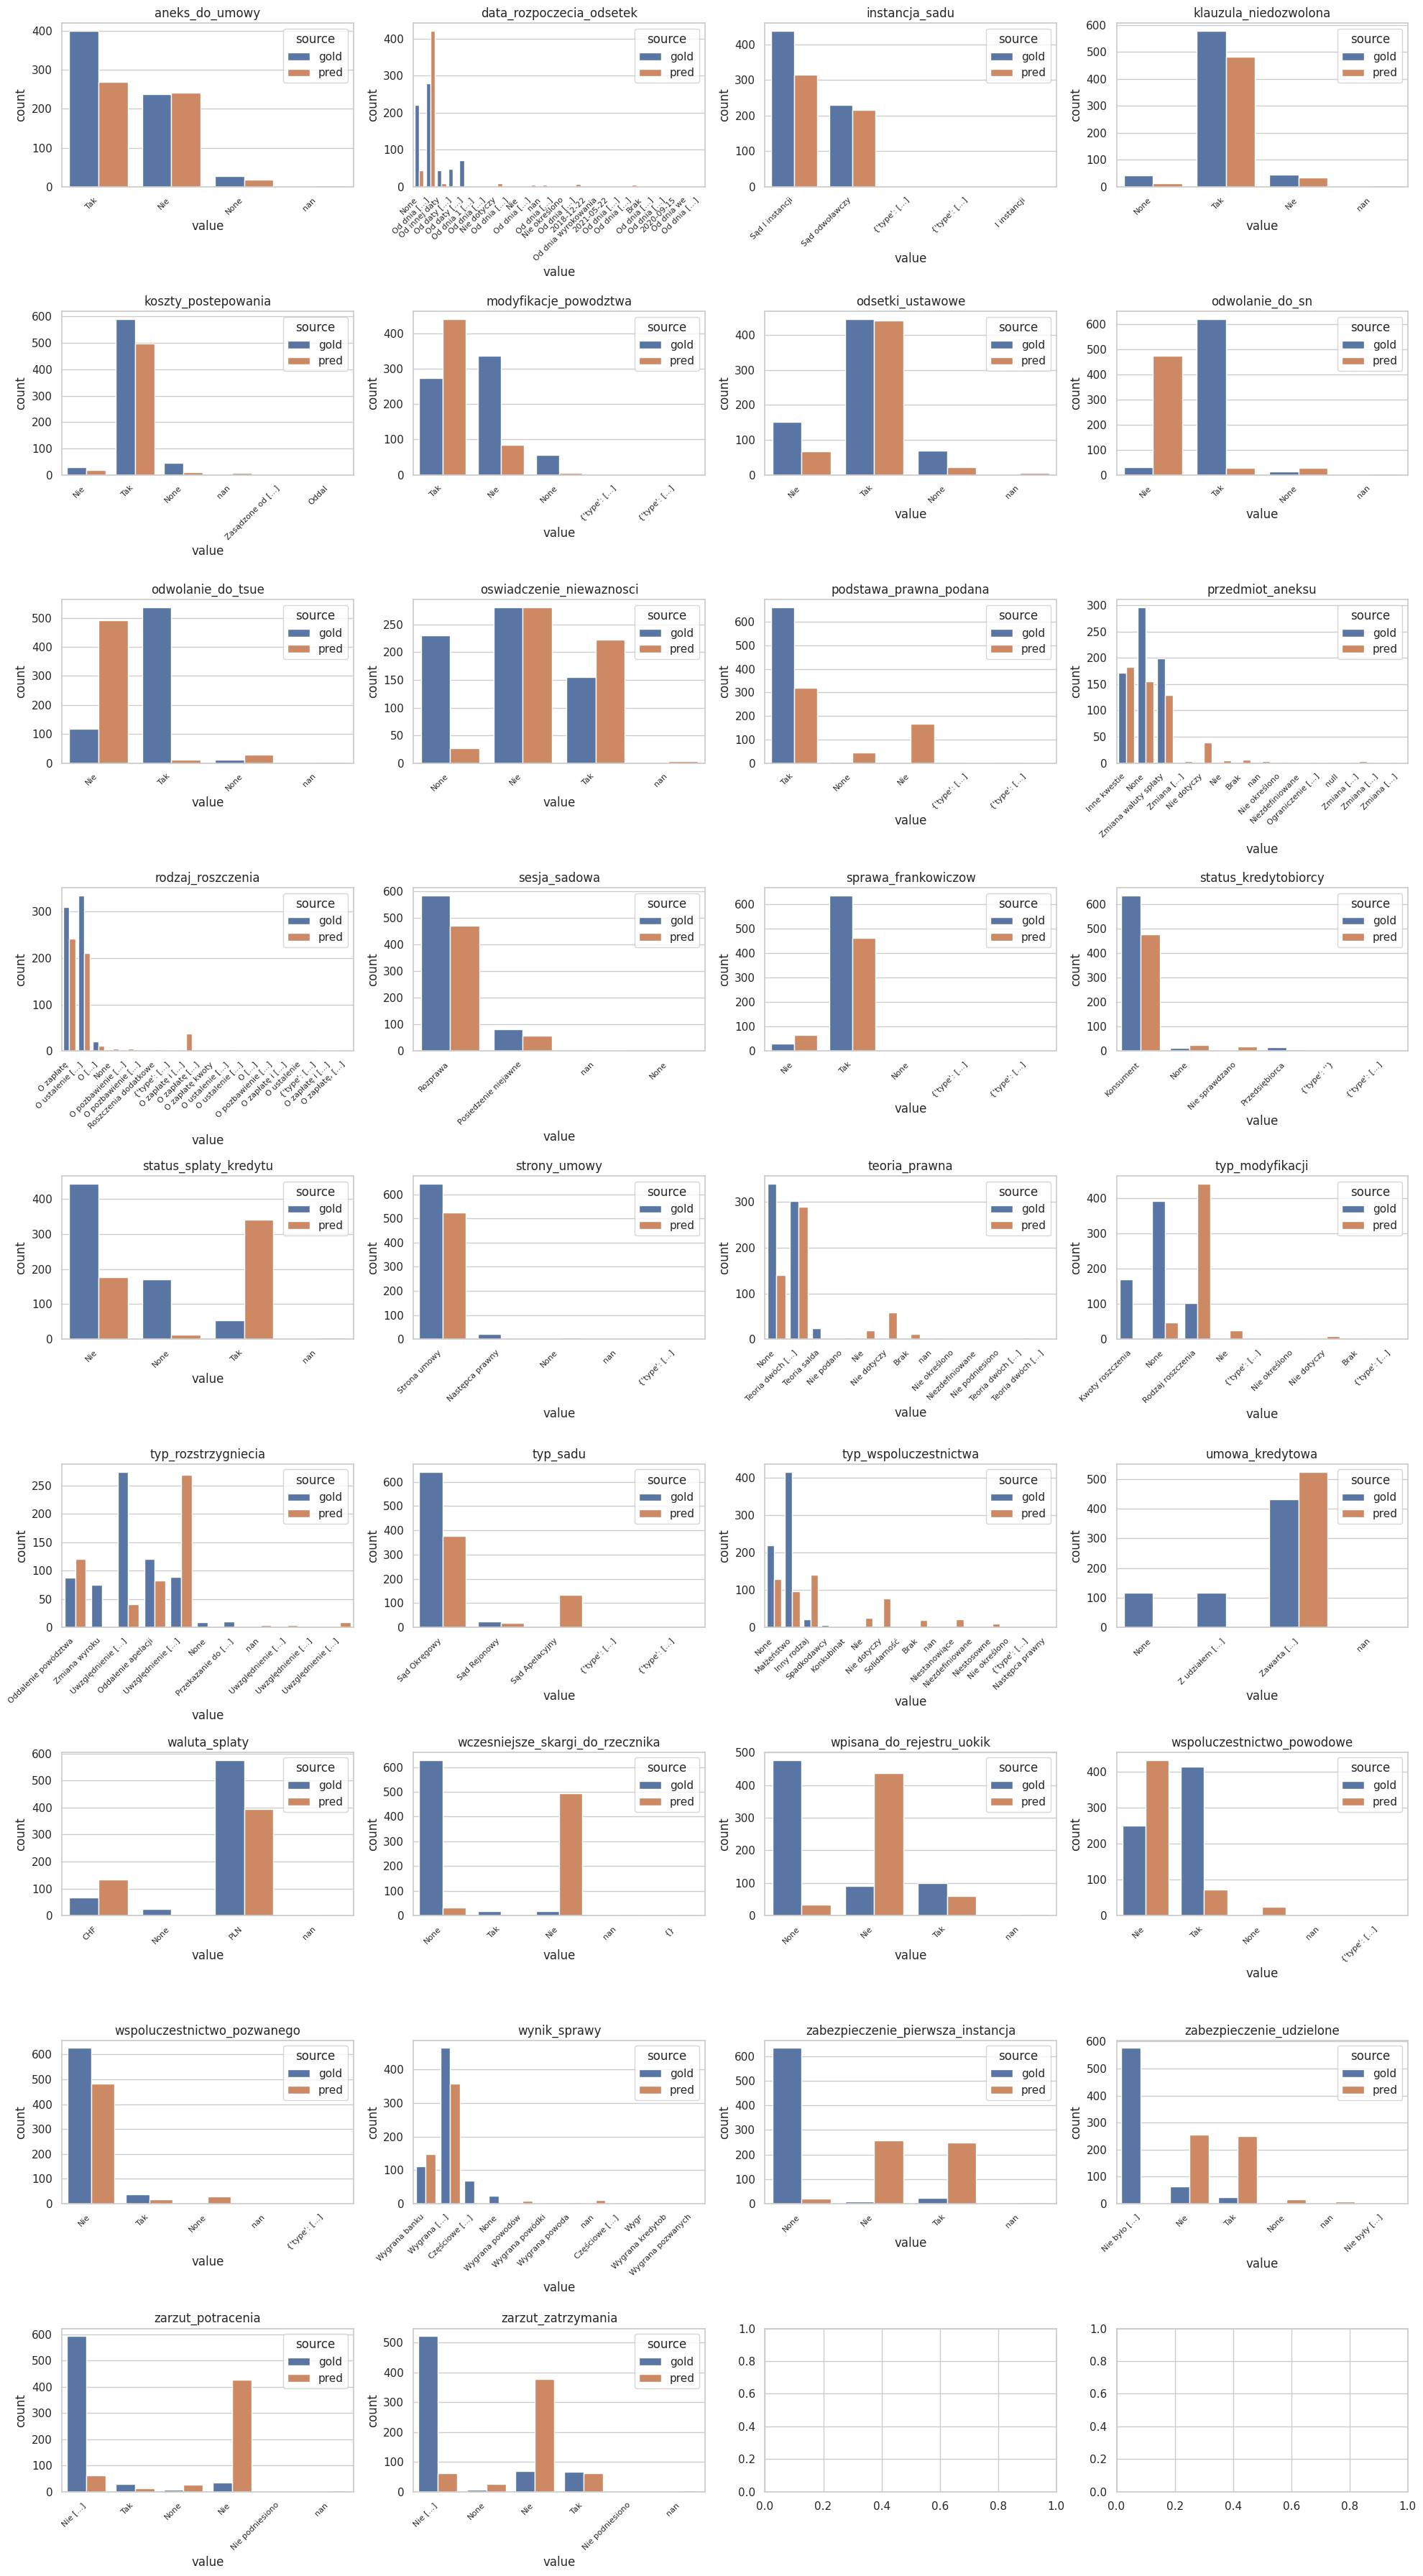

In [10]:
raw_gold_melt = raw_gold.melt(var_name="field", value_name="value")
raw_gold_melt["source"] = "gold"
raw_ans_melt = raw_ans.melt(var_name="field", value_name="value")
raw_ans_melt["source"] = "pred"
melt_df = pd.concat([raw_gold_melt, raw_ans_melt])

enums = {name:item for name, item in schema.items() if item["type"] == "enum"}
enums = dict(sorted(enums.items()))

num_cols = 4
num_rows =  math.ceil(len(enums) / num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*4))

for i, (name, enum) in enumerate(enums.items()):
    ax = axes.flatten()[i]
    data = melt_df[melt_df["field"] == name].astype(str)
    sns.countplot(x="value", data=data, hue="source", ax=ax)
    ax.tick_params(axis='x', labelsize=8)
    ax.set_title(name)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([textwrap.shorten(label.get_text(), width=20) for label in ax.get_xticklabels()], rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [11]:
def print_wrapped_table(df: pd.DataFrame, width=40):
    def wrap_text(text):
        if isinstance(text, str):
            return "\n".join(textwrap.wrap(text, width=width))
        return text

    wrapped_df = df.map(wrap_text)
    print(tabulate(wrapped_df, headers="keys", tablefmt="grid"))

In [12]:
raw_ans[["typ_modyfikacji"]].join(raw_gold[["typ_modyfikacji"]], rsuffix="_GOLD").dropna(axis=0).join(judge_raw[["typ_modyfikacji"]], rsuffix="_JUDGE", how="left")["typ_modyfikacji_JUDGE"].mean()

np.float64(0.3604060913705584)

In [13]:
def list_evaluate(pred_list: list[str], gold_list: list[str]) -> dict[str, int]:
    """
    Evaluate a list of predictions against a list of gold labels.
    """
    # Convert lists to sets for efficient comparison
    if pred_list is None:
        pred_list = []
    elif isinstance(pred_list, float) and math.isnan(pred_list):
        pred_list = []
    elif isinstance(pred_list, str):
        pred_list = pred_list.split(",")
    else:
        if not isinstance(pred_list, list):
            print(pred_list)
            raise ValueError("pred_list is not a list")
    if gold_list is None:
        return None
    
    pred_set = set(pred_list)
    gold_set = set(gold_list)
    
    # Calculate true positives, false positives, and false negatives
    true_positives = pred_set.intersection(gold_set)
    false_positives = pred_set - gold_set
    false_negatives = gold_set - pred_set
    
    # Calculate precision and recall
    try:
        precision = len(true_positives) / (len(true_positives) + len(false_positives))
    except ZeroDivisionError:
        precision = 0
    try:
        recall = len(true_positives) / (len(true_positives) + len(false_negatives))
    except ZeroDivisionError:
        recall = 0
    
    # Calculate F1 score using precision and recall
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        "true_positives": len(true_positives),
        "false_positives": len(false_positives),
        "false_negatives": len(false_negatives),
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
    }

In [14]:
# pd.DataFrame(conf_table.apply(lambda x: list_evaluate(x["dowody_RAW"], x["dowody_GOLD"]), axis=1).dropna().tolist()).mean(axis=0)

=============== typ_rozstrzygniecia ================
{'choices': ['Uwzględnienie powództwa w całości',
             'Uwzględnienie powództwa w części',
             'Oddalenie powództwa',
             'Oddalenie apelacji',
             'Zmiana wyroku',
             'Przekazanie do ponownego rozpoznania'],
 'description': 'Typ rozstrzygnięcia',
 'required': False,
 'type': 'enum'}



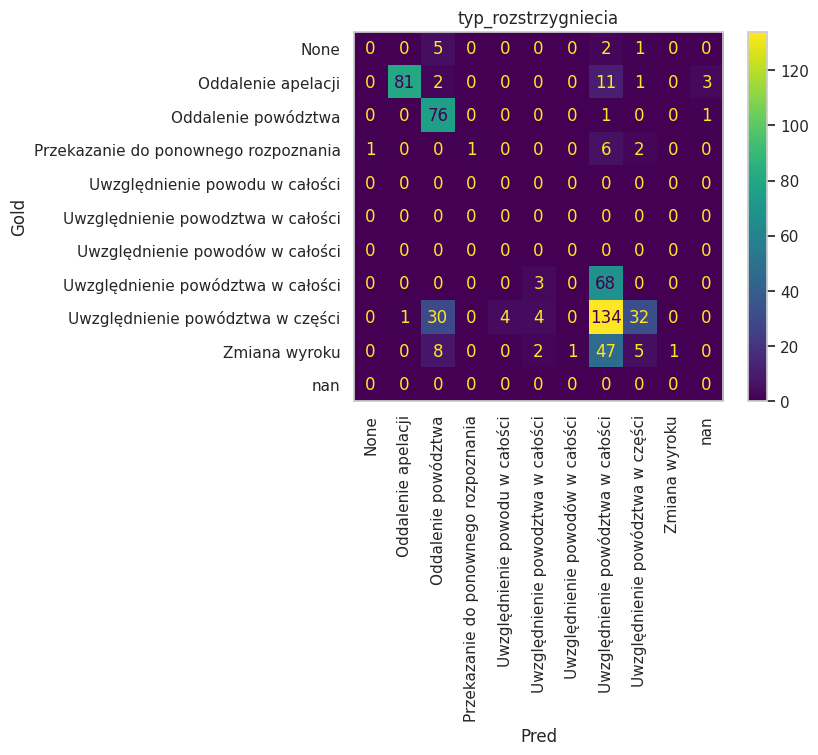

+-----+-----------------------------------+-----------------------------------+---------------------------------+
|     | typ_rozstrzygniecia               | typ_rozstrzygniecia_GOLD          |   typ_rozstrzygniecia_SFT_JUDGE |
+=====+===================================+===================================+=================================+
|   0 | Oddalenie powództwa               | Oddalenie powództwa               |                               1 |
+-----+-----------------------------------+-----------------------------------+---------------------------------+
|   1 | Oddalenie powództwa               | Zmiana wyroku                     |                               0 |
+-----+-----------------------------------+-----------------------------------+---------------------------------+
|   2 | Uwzględnienie powództwa w części  | Uwzględnienie powództwa w części  |                               0 |
+-----+-----------------------------------+-----------------------------------+---------

In [15]:
COLUMN = "typ_rozstrzygniecia"

table = (
    raw_ans[[COLUMN]]
    # .join(sft_ans[[COLUMN]], lsuffix="_RAW", rsuffix="_SFT", how="left")
    .join(sft_gold[[COLUMN]], rsuffix="_GOLD", how="left")
    .join(judge_sft[[COLUMN]], rsuffix="_SFT_JUDGE", how="left")
    .head(100)
)
print(f"=============== {COLUMN} ================")
pprint(schema[COLUMN])
print()

conf_table = raw_ans[[COLUMN]].join(sft_gold[[COLUMN]], lsuffix="_RAW", rsuffix="_GOLD", how="left")
ax = ConfusionMatrixDisplay.from_predictions(
    y_true=conf_table[COLUMN + "_GOLD"].astype(str),
    y_pred=conf_table[COLUMN + "_RAW"].astype(str),
    xticks_rotation="vertical",
).ax_
ax.set(title=COLUMN, xlabel="Pred", ylabel="Gold")
ax.grid(False)
plt.show()

print_wrapped_table(table)


### Validate LLM-as-judge

In [16]:
bad_indices = judge_raw[judge_raw.mean(axis=1) < 1.0][:10]
for index in bad_indices.index:
    index = int(index)
    table = []
    for key, value in raw_preds["answer"][index].items():
        table.append([key, value, raw_preds.iloc[index]["gold"].get(key), judge_raw.iloc[index].get(key)])

    print(tabulate(table, headers=["Key", "Pred", "Gold", "Judge"], tablefmt="grid"))
    print("\n")

+-----------------------------------+--------------------------------------------------+-----------------------------------------------------------------------------------+---------+
| Key                               | Pred                                             | Gold                                                                              |   Judge |
+===================================+==================================================+===================================================================================+=========+
| sprawa_frankowiczow               | Tak                                              | Nie                                                                               |    0    |
+-----------------------------------+--------------------------------------------------+-----------------------------------------------------------------------------------+---------+
| apelacja                          | Zanonimizowano                                 